In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
from scipy.stats import iqr

import os
import math

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import datetime
import calendar

from numpy import mean
from numpy import std

from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold

import joblib

In [2]:
names = ['class', 'handicapped-infants', 'water-project-cost-sharing', 
         'adoption-of-the-budget-resolution', 'physician-fee-freeze', 
         'el-salvador-aid', 'religious-groups-in-schools', 'anti-satellite-test-ban', 
         'aid-to-nicaraguan-contras', 'mx-missile', 'immigration', 
         'synfuels-corporation-cutback', 'education-spending', 'superfund-right-to-sue', 
         'crime', 'duty-free-exports', 'export-administration-act-south-africa']

votes = pd.read_csv('house-votes-84.data', header = None, names = names)
print(votes.shape)
votes.head(2)

(435, 17)


,class,handicapped-infants,water-project-cost-sharing,adoption-of-the-budget-resolution,physician-fee-freeze,el-salvador-aid,religious-groups-in-schools,anti-satellite-test-ban,aid-to-nicaraguan-contras,mx-missile,immigration,synfuels-corporation-cutback,education-spending,superfund-right-to-sue,crime,duty-free-exports,export-administration-act-south-africa
0,republican,n,y,n,y,y,y,n,n,n,y,?,y,y,y,n,y
1,republican,n,y,n,y,y,y,n,n,n,n,n,y,y,y,n,?


In [3]:
def print_unique(df):
    for col in df.columns:
        print(col, '\n', df[col].sort_values().unique(), '\n')
        
print_unique(votes)

class 
 ['democrat' 'republican'] 

handicapped-infants 
 ['?' 'n' 'y'] 

water-project-cost-sharing 
 ['?' 'n' 'y'] 

adoption-of-the-budget-resolution 
 ['?' 'n' 'y'] 

physician-fee-freeze 
 ['?' 'n' 'y'] 

el-salvador-aid 
 ['?' 'n' 'y'] 

religious-groups-in-schools 
 ['?' 'n' 'y'] 

anti-satellite-test-ban 
 ['?' 'n' 'y'] 

aid-to-nicaraguan-contras 
 ['?' 'n' 'y'] 

mx-missile 
 ['?' 'n' 'y'] 

immigration 
 ['?' 'n' 'y'] 

synfuels-corporation-cutback 
 ['?' 'n' 'y'] 

education-spending 
 ['?' 'n' 'y'] 

superfund-right-to-sue 
 ['?' 'n' 'y'] 

crime 
 ['?' 'n' 'y'] 

duty-free-exports 
 ['?' 'n' 'y'] 

export-administration-act-south-africa 
 ['?' 'n' 'y'] 



In [4]:
def get_snapshot(df):
    n_missing = pd.DataFrame(df.isnull().sum(), columns = ['n_missing'])
    pct_missing = pd.DataFrame(round(df.isnull().sum() / df.shape[0], 2), columns = ['pct_missing'])
    dtype = pd.DataFrame(df.dtypes, columns = ['dtype'])
    n_unique = []
    for col in df.columns:
        n_unique.append(df[col].nunique())    
    return pd.DataFrame(n_unique, index = df.columns, columns = ['n_unique']).join(dtype).join(n_missing).join(pct_missing)

In [5]:
snapshot = get_snapshot(votes)
snapshot

,n_unique,dtype,n_missing,pct_missing
class,2,object,0,0.0
handicapped-infants,3,object,0,0.0
water-project-cost-sharing,3,object,0,0.0
adoption-of-the-budget-resolution,3,object,0,0.0
physician-fee-freeze,3,object,0,0.0
el-salvador-aid,3,object,0,0.0
religious-groups-in-schools,3,object,0,0.0
anti-satellite-test-ban,3,object,0,0.0
aid-to-nicaraguan-contras,3,object,0,0.0
mx-missile,3,object,0,0.0


In [6]:
features = votes.columns.drop('class')

In [7]:
def plot_single_categorical(df, col):
    plt.figure(figsize = (4, 4))
    
    df[col].value_counts().plot.bar(color = mcolors.TABLEAU_COLORS)
    sns.despine(top = True)
    
    n_level = df[col].nunique()
    for x_coor in range(n_level):
        plt.annotate(df[col].value_counts().iloc[x_coor], 
                     xy = (x_coor, 
                           df[col].value_counts().iloc[x_coor] + df[col].value_counts().iloc[0]/50))
    
    plt.xticks(rotation = 0)
    plt.grid()
    plt.title(col)
    plt.show()

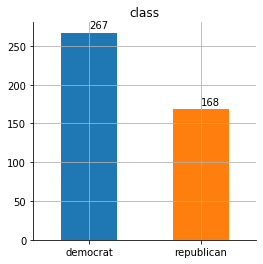

In [8]:
plot_single_categorical(votes, 'class')

In [10]:
votes_dummi = pd.get_dummies(votes, columns = features, dtype = int)

In [11]:
enc = LabelEncoder()
y = enc.fit_transform(votes['class'])

In [12]:
X = votes_dummi.drop('class', axis = 1)

In [13]:
def feat_significance(X, y, n_feat_data_type, features):
    mi_df = pd.DataFrame(mutual_info_classif(X, y, random_state = 42), index = X.columns, columns = ['score'])
    mi_df = mi_df.sort_values(by = 'score', ascending = False)
    
    def color_cell(s):    
        background = []
        for i in range(len(s.index)):
            if s.index[i] in features:
                background.append('background-color: yellow')
            else:
                background.append('')
        return background
    
    if n_feat_data_type == 1:
        return mi_df
    else:
        return mi_df.style.apply(color_cell, axis = 0)

In [17]:
feat_score = feat_significance(X, y, 1, '')
feat_score

,score
physician-fee-freeze_y,0.489080
physician-fee-freeze_n,0.484946
el-salvador-aid_n,0.309321
el-salvador-aid_y,0.305439
adoption-of-the-budget-resolution_y,0.291037
adoption-of-the-budget-resolution_n,0.285134
education-spending_y,0.240743
mx-missile_n,0.237679
crime_n,0.235595
education-spending_n,0.231166


In [28]:
feat_score.size

48

In [31]:
feat_ordered = feat_score.index[0:16]

In [15]:
lr = LogisticRegression(random_state = 42)
knn = KNeighborsClassifier()
svc = SVC(random_state = 42)
tree = DecisionTreeClassifier(max_features = 'auto', random_state = 42)
alg_dict = {lr: 'lr', svc: 'svc', knn: 'knn', tree: 'tree'}

In [16]:
def num_feat_perform(algorithm, feat_ordered, X_ordered, y, metric):
    scores = []
    for i in range(1, len(feat_ordered)+1):
        pred_data = X_ordered.iloc[:, 0:i]
        score = mean(cross_val_score(algorithm, pred_data, y, scoring = metric, cv = 5))
        scores.append(score)

    n_features = len(feat_ordered)
    plt.plot(np.arange(n_features), scores, marker = 'x')
    plt.xticks(np.arange(n_features), np.arange(1, n_features + 1))
    for i in range(n_features):
        plt.text(i, scores[i], s = round(scores[i], 2))
    plt.grid()
    plt.xlabel('no. of features')
    plt.ylabel('score')
    
def num_feat_multi_alg(alg_dict, feat_ordered, X_ordered, y, metric):
    n_algorithm = len(alg_dict)
    algorithms = list(alg_dict.keys())
    alg_names = list(alg_dict.values())
    if n_algorithm <= 2:
        nrows = 1
        ncols = n_algorithm
        fig = plt.figure(figsize = (ncols * 6, 4))
    else:
        nrows = math.ceil(n_algorithm / 2)
        ncols = 2
        fig = plt.figure(figsize = (12, nrows * 4))

    for n in range(n_algorithm):
        ax = fig.add_subplot(nrows, ncols, n + 1)
        ax = num_feat_perform(algorithms[n], feat_ordered, X_ordered, y, metric)
        plt.title(f"'{alg_names[n]}' performance by '{metric}'")
        
    plt.tight_layout()
    plt.show()

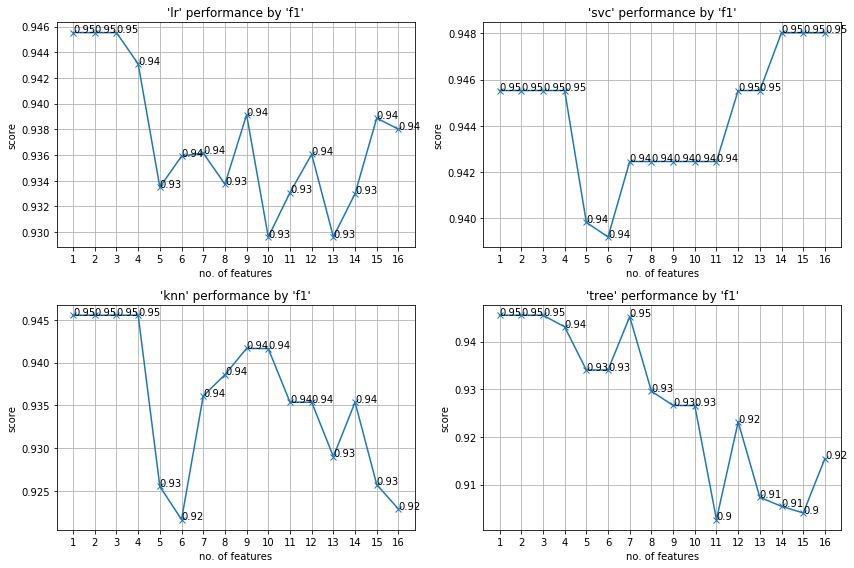

In [32]:
num_feat_multi_alg(alg_dict, feat_ordered, X[feat_ordered], y, 'f1')

In [34]:
feat_ordered[0]

'physician-fee-freeze_y'

In [33]:
def plot_learning_curve(train_scores, test_scores, train_sizes):
    train_scores = pd.DataFrame(train_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    train_scores = train_scores.join(pd.Series(train_scores.mean(axis = 1), name = 'mean'))

    test_scores = pd.DataFrame(test_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    test_scores = test_scores.join(pd.Series(test_scores.mean(axis = 1), name = 'mean'))

    plt.plot(train_scores['mean'], label = 'train_scores')
    plt.plot(test_scores['mean'], label = 'test_scores')
    plt.legend()
    plt.grid()
    plt.xlabel('no. of training samples')
    
def two_metric_graph(algorithm, X, y):
    train_sizes = np.linspace(start = 20, stop = X.shape[0] * 0.8, num = 6, dtype = int)
    fig = plt.figure(figsize = (10, 4))

    for i, metric in enumerate(['f1', 'balanced_accuracy']):
        train_sizes_abs, train_scores, test_scores = learning_curve(algorithm, X, y, train_sizes = train_sizes, 
                                                                    scoring = metric, cv = 5, shuffle = True, 
                                                                    random_state = 42)
        ax = fig.add_subplot(1, 2, i + 1)
        ax = plot_learning_curve(train_scores, test_scores, train_sizes)
        plt.title(f"'performance by '{metric}'")

    plt.tight_layout()
    plt.show()

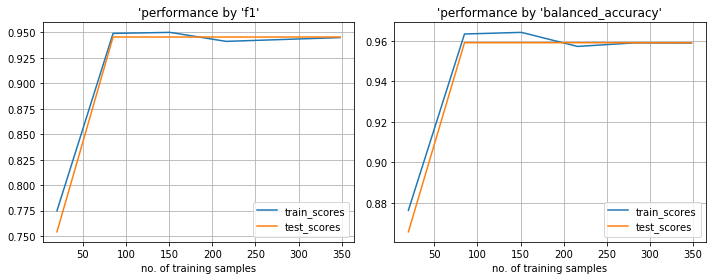

In [36]:
two_metric_graph(lr, X[[feat_ordered[0]]], y)

In [37]:
lr.fit(X[[feat_ordered[0]]], y)
joblib.dump(lr, 'lr.joblib')

['lr.joblib']